In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import os
import pickle
import featuretools as ft
from pathlib import Path
from supersqlite import sqlite3
import featuretools.variable_types as vtypes
import hvplot.pandas

/Users/bryan/.pyenv/versions/3.7.4/envs/Capstone/lib/python3.7/site-packages/supersqlite/third_party/internal/pysqlite2/dbapi2.py:59: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  collections.Sequence.register(Row)
/Users/bryan/.pyenv/versions/3.7.4/envs/Capstone/lib/python3.7/site-packages/holoviews/core/data/grid.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import OrderedDict, defaultdict, Iterable


### Make Original DataFrame

In [2]:
conn = sqlite3.connect(Path(Path.cwd().parent, "data", "processed", "fta.db"))
event = pd.read_sql_query("SELECT * FROM events", conn)
summary = pd.read_sql_query("SELECT case_id,party from summary", conn)

In [3]:
# Create unique index
event["event_id"] = event.index

In [4]:
# Convert result to binary
event["result"] = event["result"].map(
    lambda x: 1 if x == "Defendant Failed to Appear" else 0
)

In [5]:
# Parse datetime column
event["datetime"] = pd.to_datetime(event["datetime"])

In [6]:
# Remove events where its datetime is missing
event = event.dropna(subset=["datetime"])
# Remove rows where all fileds are the same
event.drop_duplicates(inplace=True)
summary.drop_duplicates(inplace=True)

In [7]:
# Merge summary table for consumer entity
event = event.merge(summary, how="left", on="case_id")
event["consumer_id"] = event["party"].astype("category").cat.codes
event.head()

year            datetime        location                 type  result  \
0  2017 2017-01-02 11:00:00  Courtroom C-10          Presentment       0   
1  2017 2017-01-23 11:00:00   Courtroom 301  Preliminary Hearing       0   
2  2017 2017-01-02 11:00:00  Courtroom C-10          Presentment       0   
3  2017 2017-01-05 09:00:00   Courtroom 301  Preliminary Hearing       0   
4  2017 2017-02-23 09:00:00   Courtroom 301    Detention Hearing       0   

           judge          case_id  event_id              party  consumer_id  
0  ARTHUR, ERROL  2017 CF2 000010         0    MILLER, CARLTON        15096  
1  ARTHUR, ERROL  2017 CF2 000010         1    MILLER, CARLTON        15096  
2  ARTHUR, ERROL  2017 CF2 000013         2  THOMPSON, DAMONTA        21514  
3  ARTHUR, ERROL  2017 CF2 000013         3  THOMPSON, DAMONTA        21514  
4  ARTHUR, ERROL  2017 CF2 000013         4  THOMPSON, DAMONTA        21514

### Create Entity

In [8]:
variable_types = {
    "result": ft.variable_types.Numeric,
    "judge": ft.variable_types.Categorical,
    "location": ft.variable_types.Categorical,
    "type": ft.variable_types.Categorical,
    "year": ft.variable_types.Ordinal,
    "case_id": ft.variable_types.Categorical,
    "consumer_id": ft.variable_types.Categorical,
}

In [9]:
# Events
es = ft.EntitySet(id="Events")
es = es.entity_from_dataframe(
    entity_id="events",
    dataframe=event,
    index="event_id",
    time_index="datetime",
    variable_types=variable_types,
)

In [10]:
# Cases
es.normalize_entity(
    "events",
    "cases",
    "case_id",
    additional_variables=["consumer_id", "judge", "location", "type", "result"],
)

Entityset: Events
  Entities:
    events [Rows: 336213, Columns: 5]
    cases [Rows: 32233, Columns: 7]
  Relationships:
    events.case_id -> cases.case_id

In [11]:
# Consumers
es.normalize_entity("cases", "consumers", "consumer_id")

Entityset: Events
  Entities:
    events [Rows: 336213, Columns: 5]
    cases [Rows: 32233, Columns: 7]
    consumers [Rows: 24635, Columns: 2]
  Relationships:
    events.case_id -> cases.case_id
    cases.consumer_id -> consumers.consumer_id

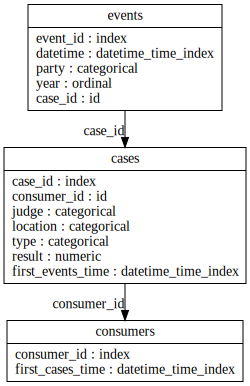

In [12]:
es.plot()

### Create Cutoff

In [13]:
cutoffs = es["cases"].df[["case_id", "first_events_time"]]
cutoffs = cutoffs.reset_index()
cutoffs.drop("index", axis=1, inplace=True)
cutoffs.rename(columns={"first_events_time": "time"}, inplace=True)
cutoffs

case_id                time
0      2012 CF2 016611 1922-01-01 10:30:00
1      2012 CF2 006803 2002-09-11 09:30:00
2      2007 CF2 000003 2007-01-01 11:00:00
3      2007 CF2 000011 2007-01-01 11:00:00
4      2007 CF2 000024 2007-01-01 11:00:00
...                ...                 ...
32228  2019 CF2 011491 2019-09-05 13:00:00
32229  2019 CF2 011527 2019-09-05 13:00:00
32230  2019 CF2 011528 2019-09-05 13:00:00
32231  2019 CF2 011531 2019-09-05 13:00:00
32232  2019 CF2 011256 2019-09-12 09:30:00

[32233 rows x 2 columns]

### Make Labels

In [14]:
labels_df = (
    event[["case_id", "result"]].groupby("case_id").result.sum() == 1
).to_frame()
cutoffs = cutoffs.merge(labels_df, how="left", on="case_id")
cutoffs = cutoffs.rename(columns={"result": "label"})
cutoffs.head()

case_id                time  label
0  2012 CF2 016611 1922-01-01 10:30:00  False
1  2012 CF2 006803 2002-09-11 09:30:00  False
2  2007 CF2 000003 2007-01-01 11:00:00  False
3  2007 CF2 000011 2007-01-01 11:00:00  False
4  2007 CF2 000024 2007-01-01 11:00:00  False

In [15]:
fm, features = ft.dfs(
    entityset=es, target_entity="cases", cutoff_time=cutoffs, agg_primitives=["count","sum"],cutoff_time_in_index=True
)

In [16]:
fm.head()

consumer_id judge        location  \
case_id         time                                                     
2012 CF2 016611 1922-01-01 10:30:00        22468  None   Courtroom 312   
2012 CF2 006803 2002-09-11 09:30:00        23201  None   Courtroom 321   
2007 CF2 000003 2007-01-01 11:00:00         2219  None  Courtroom C-10   
2007 CF2 000011 2007-01-01 11:00:00        15111  None  Courtroom C-10   
2007 CF2 000024 2007-01-01 11:00:00         2630  None  Courtroom C-10   

                                                   type  result  \
case_id         time                                              
2012 CF2 016611 1922-01-01 10:30:00  Felony Arraignment       0   
2012 CF2 006803 2002-09-11 09:30:00          Jury Trial       0   
2007 CF2 000003 2007-01-01 11:00:00         Presentment       0   
2007 CF2 000011 2007-01-01 11:00:00         Presentment       0   
2007 CF2 000024 2007-01-01 11:00:00         Presentment       0   

                                     COUNT(events)  DAY(first_events_time)  \
case_id         time                                                         
2012 CF2 016611 1922-01-01 10:30:00              1                       1   
2012 CF2 006803 2002-09-11 09:30:00              1                      11   
2007 CF2 000003 2007-01-01 11:00:00              1                       1   
2007 CF2 000011 2007-01-01 11:00:00              1                       1   
2007 CF2 000024 2007-01-01 11:00:00              1                       1   

                                     YEAR(first_events_time)  \
case_id         time                                           
2012 CF2 016611 1922-01-01 10:30:00                     1922   
2012 CF2 006803 2002-09-11 09:30:00                     2002   
2007 CF2 000003 2007-01-01 11:00:00                     2007   
2007 CF2 000011 2007-01-01 11:00:00                     2007   
2007 CF2 000024 2007-01-01 11:00:00                     2007   

                                     MONTH(first_events_time)  \
case_id         time                                            
2012 CF2 016611 1922-01-01 10:30:00                         1   
2012 CF2 006803 2002-09-11 09:30:00                         9   
2007 CF2 000003 2007-01-01 11:00:00                         1   
2007 CF2 000011 2007-01-01 11:00:00                         1   
2007 CF2 000024 2007-01-01 11:00:00                         1   

                                     WEEKDAY(first_events_time)  \
case_id         time                                              
2012 CF2 016611 1922-01-01 10:30:00                           6   
2012 CF2 006803 2002-09-11 09:30:00                           2   
2007 CF2 000003 2007-01-01 11:00:00                           0   
2007 CF2 000011 2007-01-01 11:00:00                           0   
2007 CF2 000024 2007-01-01 11:00:00                           0   

                                     consumers.COUNT(cases)  \
case_id         time                                          
2012 CF2 016611 1922-01-01 10:30:00                       1   
2012 CF2 006803 2002-09-11 09:30:00                       1   
2007 CF2 000003 2007-01-01 11:00:00                       1   
2007 CF2 000011 2007-01-01 11:00:00                       1   
2007 CF2 000024 2007-01-01 11:00:00                       1   

                                     consumers.SUM(cases.result)  \
case_id         time                                               
2012 CF2 016611 1922-01-01 10:30:00                            0   
2012 CF2 006803 2002-09-11 09:30:00                            0   
2007 CF2 000003 2007-01-01 11:00:00                            0   
2007 CF2 000011 2007-01-01 11:00:00                            0   
2007 CF2 000024 2007-01-01 11:00:00                            0   

                                     consumers.COUNT(events)  \
case_id         time                                           
2012 CF2 016611 1922-01-01 10:30:00                        1   
2012 CF2 006803

In [17]:
fm.columns

Index(['consumer_id', 'judge', 'location', 'type', 'result', 'COUNT(events)',
       'DAY(first_events_time)', 'YEAR(first_events_time)',
       'MONTH(first_events_time)', 'WEEKDAY(first_events_time)',
       'consumers.COUNT(cases)', 'consumers.SUM(cases.result)',
       'consumers.COUNT(events)', 'consumers.DAY(first_cases_time)',
       'consumers.YEAR(first_cases_time)', 'consumers.MONTH(first_cases_time)',
       'consumers.WEEKDAY(first_cases_time)', 'label'],
      dtype='object')

In [18]:
# How many fta happens before a new case for a consumer?
# In one single case, there could be multiple FTAs
X = fm[["consumers.SUM(cases.result)"]].values
y = fm["label"].values

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(random_state=0, solver='lbfgs')

/Users/bryan/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/bryan/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/bryan/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/bryan/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/bryan/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstra

In [20]:
# Currently, this model predicts all results as False. Need parameters tunning and try more new features.
cross_val_score(clf, X, y, cv=3)

array([0.83825035, 0.83925912, 0.83870067])

## FTA based on weekday

In [21]:
event["weekday"] = event["datetime"].dt.day_name()
fta_weekday = (
    event.iloc[np.where(event["result"].values == True)]["weekday"]
    .value_counts()
    .sort_index()
)
fta_percentange = (
    fta_weekday / event["weekday"].value_counts().sort_index().loc[fta_weekday.index]
)
fta_percentange = fta_percentange.to_frame()
fta_percentange["value"] = fta_percentange["weekday"]
fta_percentange["label"] = fta_percentange.index
fta_percentange["weekday"] = fta_percentange["label"]
fta_percentange

weekday     value      label
Friday        Friday  0.042350     Friday
Monday        Monday  0.034381     Monday
Thursday    Thursday  0.034864   Thursday
Tuesday      Tuesday  0.041512    Tuesday
Wednesday  Wednesday  0.038827  Wednesday

In [22]:
fta_percentange.hvplot.bar(
    x="weekday", y="value", ylim=(0, 0.05)
) * fta_percentange.hvplot.labels("weekday", "value", "label").options(
    text_font_size="10pt", yoffset=0.002, text_color="black"
)

:Overlay
   .Bars.I   :Bars   [weekday]   (value)
   .Labels.I :Labels   [weekday,value]   (label)